In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json 
import scipy.io
import h5py
import pandas as pd

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet
import importlib
importlib.reload(topnet)

<module 'topnet' from '/home/ephy/Projects/tda_convolution/src/topnet.py'>

In [2]:
datadir='/home/ephy/Projects/cytoplasmic_streaming/data/altered/filament_images/filament_images/'

In [106]:
# Have to get the images in order
nets = []
for i in np.arange(150):
    i=str(i+1)
    file='net'+i+'.png'
    nets.append([cv2.imread(datadir+file, cv2.IMREAD_GRAYSCALE)])

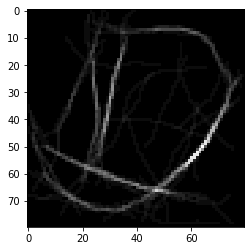

In [111]:
plt.imshow(nets[1][0],cmap='gray')

In [112]:
labels = []
for i in range(50):
    labels.append(np.eye(3)[0])
for i in range(50):
    labels.append(np.eye(3)[1])
for i in range(50):
    labels.append(np.eye(3)[2])
labels = np.array(labels,dtype=np.float32)

In [129]:
train_X , test_X , train_y , test_y = train_test_split(nets , labels, 
                                                test_size = 0.1,
                                                random_state = 1)

In [131]:
train_y[0]

tensor([1., 0., 0.], device='cuda:0')

In [130]:
train_X = torch.tensor(train_X,dtype=torch.float).to(device)
train_y = torch.tensor(train_y,dtype=torch.float).to(device)
test_X = torch.tensor(test_X,dtype=torch.float).to(device)
test_y = torch.tensor(test_y,dtype=torch.float).to(device)

In [90]:
((20-2)**2)

324

In [234]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1,64,3)
        self.fc1 = nn.Linear(462080, 500)
        self.fc2 = nn.Linear(500, 3)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(4,4))
        x = F.relu(x.view(-1,462080))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [235]:
def test(net):
    with torch.no_grad():
        out = torch.argmax(net(test_X),axis=1)
        return(sum(np.int32((out == torch.argmax(test_y,axis=1)).cpu()))/test_y.shape[0])       

In [236]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-4)
batchSize = 20
lossrec=[]
accrec = []
for epoch in range(30):
    for n in range(0, train_X.size()[0], batchSize):
        batch_X = train_X[n:n+batchSize]
        batch_y = train_y[n:n+batchSize]
        net.zero_grad()
        outputs = net(batch_X)
        loss = nn.MSELoss()(outputs, batch_y)
        lossrec.append(loss.tolist())
        loss.backward()
        optimizer.step()
        if n%10==0:
            accrec.append(test(net))

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([20, 3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: shape '[-1, 462080]' is invalid for input of size 346560

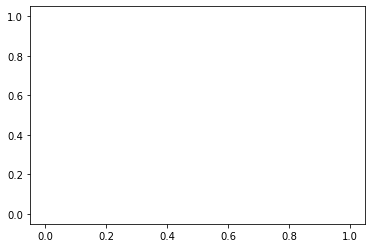

In [232]:
plt.plot(accrec)
plt.show()

In [204]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-4)
grids = torch.tensor(topnet.primary_circle(3,64)).to(device)
with torch.no_grad():
    for i,weight in enumerate(net.conv1.weight):
        net.conv1.weight[i] = torch.nn.Parameter(grids[i])
    net.conv1.requires_grad = False

In [219]:
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-4)
batchSize = 20
lossrec=[]
accrec = []
for epoch in range(30):
    for n in range(0, train_X.size()[0], batchSize):
        batch_X = train_X[n:n+batchSize]
        batch_y = train_y[n:n+batchSize]
        net.zero_grad()
        outputs = net(batch_X)
        loss = nn.MSELoss()(outputs, batch_y)
        lossrec.append(loss.tolist())
        loss.backward()
        optimizer.step()
        if n%10==0:
            accrec.append(test(net))

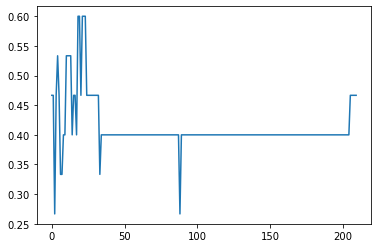

In [220]:
plt.plot(accrec)
plt.show()